# lidar data from the Lunar Reconnaissance Orbiter (LRO) Lunar Orbiter Laser Altimeter (LOLA) within bounds `(0, 85, 2, 90)`

In [1]:
from pathlib import Path

import numpy
import pandas
from Terrain_Trees import Mesh
from pyproj import CRS
from scipy.spatial import Delaunay

In [2]:
data_directory = Path('/home/zrb/Data/doctoral/')
input_filename = data_directory / 'RDR_0E2E_85N90NPointPerRow_csv_table/RDR_0E2E_85N90NTopoFull_csv_table.csv'
output_filename = data_directory / 'RDR_0E2E_85N90N.tri'

## map of data

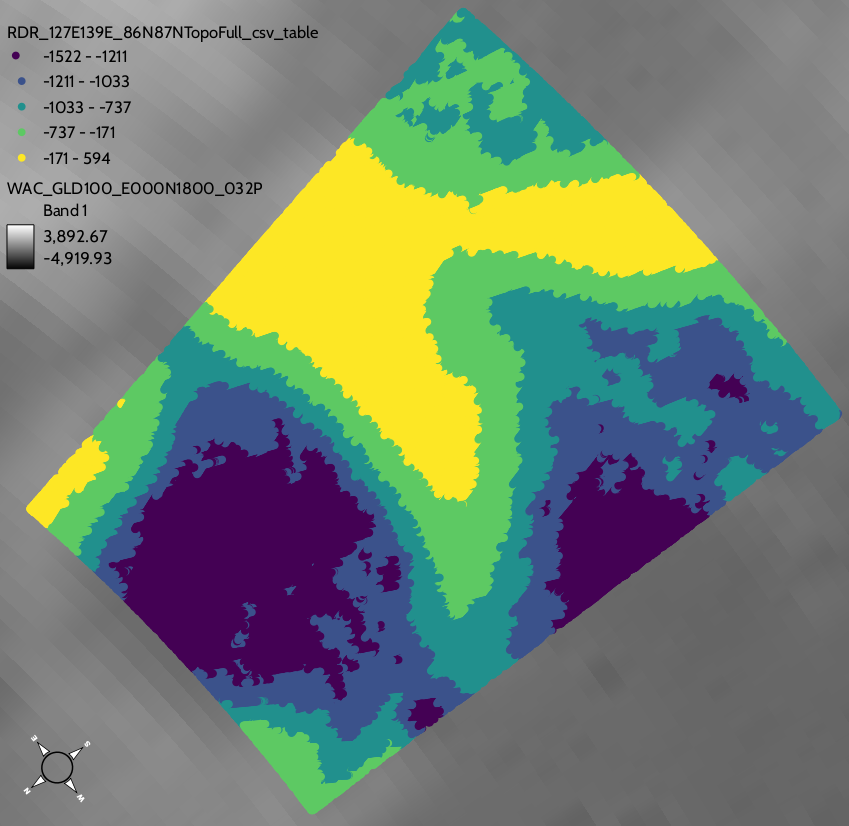

In [3]:
from IPython.display import Image
Image(filename=data_directory / 'lro_lola_crater.png')

## CRS of data

In [4]:
crs = CRS.from_string('IAU_2015:30100')
crs

<Geographic 2D CRS: IAU_2015:30100>
Name: Moon (2015) - Sphere / Ocentric
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: Moon (2015) - Sphere
- Ellipsoid: Moon (2015) - Sphere
- Prime Meridian: Reference Meridian

## convert data into `.tri` triangle mesh format

In [5]:
data = pandas.read_csv(
    input_filename,
    parse_dates=['Coordinated_Universal_Time  '],
)
data

,Pt_Longitude,Pt_Latitude,topography,Coordinated_Universal_Time,S
0,1.515952,88.613043,-1613.03,2009-09-18 03:09:10.953842580,4
1,1.259259,88.626537,-1450.08,2009-09-18 03:09:11.239557800,4
2,1.089976,88.636627,-1440.15,2009-09-18 03:09:11.418128730,3
3,0.966469,88.641687,-1457.83,2009-09-18 03:09:11.560985510,4
4,0.893437,88.646715,-1476.52,2009-09-18 03:09:11.632413980,3
...,...,...,...,...,...
481192,0.618287,85.210488,-1407.13,2011-12-03 19:51:51.152621750,4
481193,0.636331,85.202157,-1406.93,2011-12-03 19:51:51.331192310,3
481194,0.657657,85.188962,-1380.89,2011-12-03 19:51:51.581192550,3
481195,0.672875,85.179539,-1375.15,2011-12-03 19:51:51.759765090,3


In [6]:
points = data[['Pt_Longitude', ' Pt_Latitude', 'topography ']].values
triangulation = Delaunay(points[:, :2])
triangulation.simplices

array([[ 49888, 273755, 267178],
       [ 46314,  46318, 154083],
       [154838, 273603, 267178],
       ...,
       [130618, 200389, 130614],
       [ 96461, 243747, 394718],
       [243747,  96461, 407880]], dtype=int32)

In [7]:
with open(output_filename, 'w') as output_file:
    output_file.write(f'{len(triangulation.points)}\n')
    numpy.savetxt(output_file, triangulation.points, fmt='%f', delimiter=' ')
    output_file.write(f'{len(triangulation.simplices)}\n')
    numpy.savetxt(output_file, triangulation.simplices, fmt='%d', delimiter=' ')

## use `Terrain_Trees` library to read triangle mesh file

In [8]:
mesh = Mesh.from_file(str(output_filename))
mesh

[NOTA] The points are embedded in a 2D space.


In [9]:
mesh.vertices[1].coords

[1.515952, 88.613043]